#Method/Idea
Use Canny filters/Sobel filters to get an outline of Cra and road edges from depth data. Then employ a keypoint/feature detector like ORB or FAST to find keypoints. Then use the detection/bbox from yolo-model to suppress the poitns inside the car (keypoints of car). The rest of the points are the road's Edge points which can be stored and then curve-fitted.

In [1]:
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def highpass(img, sigma):
    return img - cv2.GaussianBlur(img, (0,0), sigma) + 127

shape is: (480, 640)
b is:
[[17.758646 17.758629 17.758612 ... 29.188171 29.234396 29.28077 ]
 [17.755836 17.75582  17.755802 ... 29.162174 29.208319 29.254608]
 [17.753029 17.75301  17.752993 ... 29.136227 29.182287 29.228498]
 ...
 [13.82767  13.841823 13.856004 ... 17.48106  17.537117 17.593534]
 [13.812746 13.826869 13.84102  ... 17.42822  17.48394  17.540016]
 [13.797854 13.811947 13.826067 ... 17.3757   17.431084 17.48682 ]]
29.28077 13.797854


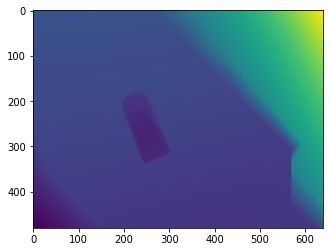

In [4]:
b = np.load('/content/drive/MyDrive/interiit/drone_image/depth/depth_camera_image10.npy')
print("shape is:",b.shape)
print("b is:")
print(b)
imshow(b)
print(np.max(b),np.min(b))

255.0 0.0


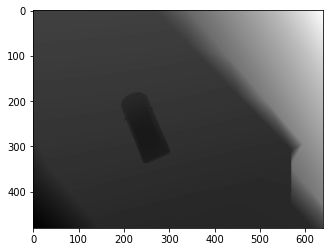

In [5]:
b = b-np.min(b)
b = b/np.max(b)
b = 255*b
b = np.floor(b)
print(np.max(b),np.min(b))

plt.imshow(b, cmap = 'gray')

[[127 127 127 ...  52  54  55]
 [127 127 127 ...  52  55  56]
 [127 127 127 ...  54  56  58]
 ...
 [127 127 127 ...  53  51  51]
 [127 127 127 ...  51  47  46]
 [127 127 127 ...  50  47  45]]


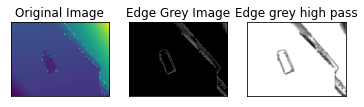

In [21]:
aperture_size = 5
img = np.uint8(b)
edges = cv2.Canny(img,1,150,apertureSize=aperture_size)

edge_pass = highpass(edges, 3)
print(edge_pass)

plt.subplot(131),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Grey Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(edge_pass, cmap = 'gray')
plt.title('Edge grey high pass'), plt.xticks([]), plt.yticks([])
#plt.savefig(str(i)+'_edge.png')
plt.show()

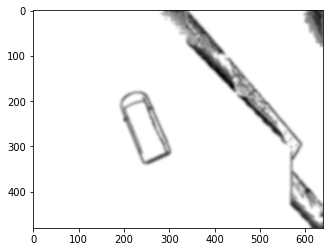

In [10]:
plt.imshow(edge_pass,cmap='gray')

Threshold: 10
nonmaxSuppression:True
neighborhood: 2
Total Keypoints with nonmaxSuppression: 9


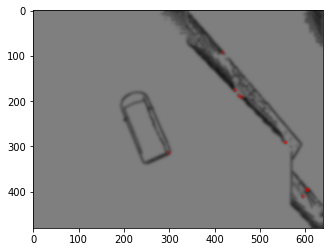

In [11]:
fast = cv2.FastFeatureDetector_create()
# find and draw the keypoints
kp = fast.detect(edge_pass,None)
img2 = cv2.drawKeypoints(edge_pass, kp, None, color=(255,0,0))
# Print all default params
print( "Threshold: {}".format(fast.getThreshold()) )
print( "nonmaxSuppression:{}".format(fast.getNonmaxSuppression()) )
print( "neighborhood: {}".format(fast.getType()) )
print( "Total Keypoints with nonmaxSuppression: {}".format(len(kp)) )
# cv2.imwrite('fast_true.png', img2)
plt.imshow(img2)

25


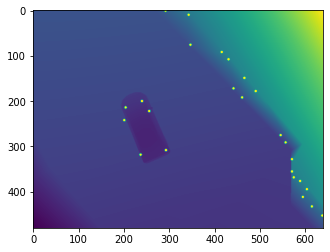

In [15]:
img = b
corners = cv2.goodFeaturesToTrack(edge_pass,25,0.01,10)
corners = np.int0(corners)
print(len(corners))

for i in corners:
    x,y = i.ravel()
    cv2.circle(img,(x,y),3,255,-1)
plt.imshow(img)
plt.show()

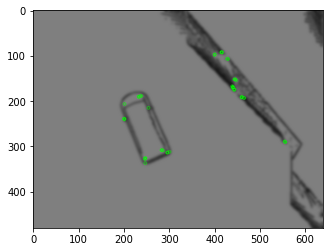

(<matplotlib.image.AxesImage at 0x7f18cf2b6550>, None)

In [16]:
# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints with ORB
kp = orb.detect(edge_pass,None)
# compute the descriptors with ORB
kp, des = orb.compute(edge_pass, kp)
# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(edge_pass, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

# trying Sobel on Edge_apss then getting Features

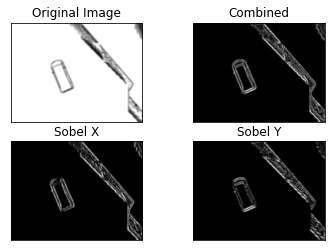

In [17]:
sobelX = cv2.Sobel(edge_pass, cv2.CV_64F, 1, 0)
sobelY = cv2.Sobel(edge_pass, cv2.CV_64F, 0, 1)
sobelX = np.uint8(np.absolute(sobelX))
sobelY = np.uint8(np.absolute(sobelY))
sobelCombined = cv2.bitwise_or(sobelX, sobelY)
titles = ['Original Image', 'Combined',
            'Sobel X', 'Sobel Y']
images = [edge_pass, sobelCombined, sobelX, sobelY]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

Threshold: 10
nonmaxSuppression:True
neighborhood: 2
Total Keypoints with nonmaxSuppression: 1562


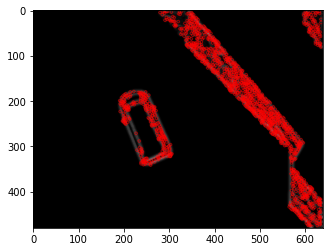

In [18]:
fast = cv2.FastFeatureDetector_create()
kp = fast.detect(sobelCombined,None)
img3 = cv2.drawKeypoints(sobelCombined, kp, None, color=(255,0,0))
print( "Threshold: {}".format(fast.getThreshold()) )
print( "nonmaxSuppression:{}".format(fast.getNonmaxSuppression()) )
print( "neighborhood: {}".format(fast.getType()) )
print( "Total Keypoints with nonmaxSuppression: {}".format(len(kp)) )
plt.imshow(img3)

25


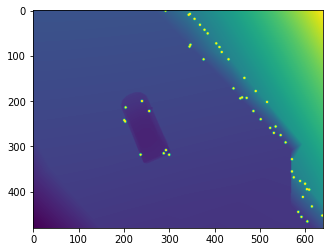

(<matplotlib.image.AxesImage at 0x7f18c67d5a10>, None)

In [20]:
img = b
corners = cv2.goodFeaturesToTrack(sobelCombined,25,0.01,10)
corners = np.int0(corners)
print(len(corners))
for i in corners:
    x,y = i.ravel()
    cv2.circle(img,(x,y),3,255,-1)
plt.imshow(img),plt.show()

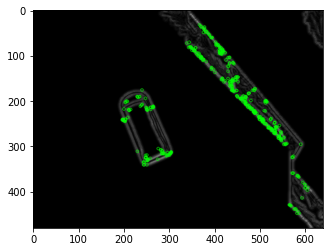

(<matplotlib.image.AxesImage at 0x7fbf9382d1d0>, None)

In [ ]:
# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints with ORB
kp = orb.detect(edge_pass,None)
# compute the descriptors with ORB
kp, des = orb.compute(edge_pass, kp)
# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(edge_pass, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

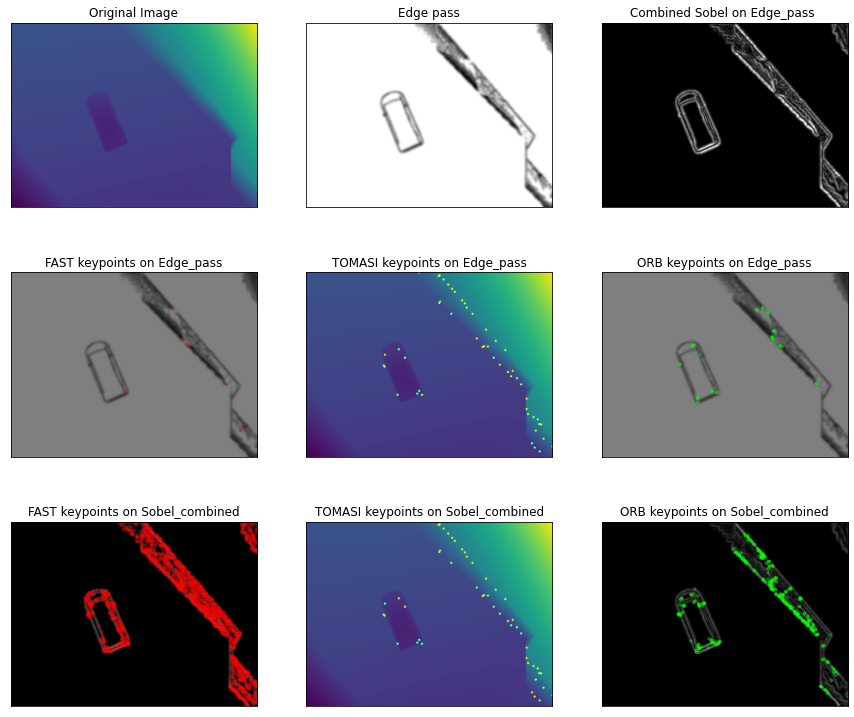

In [26]:
b = np.load('/content/drive/MyDrive/interiit/drone_image/depth/depth_camera_image10.npy')
b = b-np.min(b)
b = b/np.max(b)
b = 255*b
b = np.floor(b)

aperture_size = 5
img = np.uint8(b)
edges = cv2.Canny(img,1,150,apertureSize=aperture_size)
edge_pass = highpass(edges, 3)

#EDGE(Canny)
fast = cv2.FastFeatureDetector_create()
kp = fast.detect(edge_pass,None)
FAST_edge = cv2.drawKeypoints(edge_pass, kp, None, color=(255,0,0))

TOMASI_edge = b
corners = cv2.goodFeaturesToTrack(edge_pass,25,0.01,10)
corners = np.int0(corners)
for i in corners:
    x,y = i.ravel()
    cv2.circle(TOMASI_edge,(x,y),3,255,-1)

orb = cv2.ORB_create()
kp = orb.detect(edge_pass,None)
kp, des = orb.compute(edge_pass, kp)
ORB_edge = cv2.drawKeypoints(edge_pass, kp, None, color=(0,255,0), flags=0)

#SOBEL
sobelX = cv2.Sobel(edge_pass, cv2.CV_64F, 1, 0)
sobelY = cv2.Sobel(edge_pass, cv2.CV_64F, 0, 1)
sobelX = np.uint8(np.absolute(sobelX))
sobelY = np.uint8(np.absolute(sobelY))
sobelCombined = cv2.bitwise_or(sobelX, sobelY)

fast = cv2.FastFeatureDetector_create()
kp = fast.detect(sobelCombined,None)
FAST_sobel = cv2.drawKeypoints(sobelCombined, kp, None, color=(255,0,0))

TOMASI_sobel = b
corners = cv2.goodFeaturesToTrack(sobelCombined,25,0.01,10)
corners = np.int0(corners)
for i in corners:
    x,y = i.ravel()
    cv2.circle(TOMASI_sobel,(x,y),3,255,-1)

orb = cv2.ORB_create()
kp = orb.detect(sobelCombined,None)
kp, des = orb.compute(sobelCombined, kp)
ORB_sobel = cv2.drawKeypoints(sobelCombined, kp, None, color=(0,255,0), flags=0)

#image
plt.rcParams['figure.figsize'] = [15, 13]
plt.subplot(3,3,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(3,3,2),plt.imshow(edge_pass, cmap = 'gray')
plt.title('Edge pass'), plt.xticks([]), plt.yticks([])
plt.subplot(3,3,3), plt.imshow(sobelCombined, cmap = 'gray')
plt.title('Combined Sobel on Edge_pass '), plt.xticks([]), plt.yticks([])

plt.subplot(3,3,4),plt.imshow(FAST_edge)
plt.title('FAST keypoints on Edge_pass'), plt.xticks([]), plt.yticks([])
plt.subplot(3,3,5),plt.imshow(TOMASI_edge)
plt.title('TOMASI keypoints on Edge_pass'), plt.xticks([]), plt.yticks([])
plt.subplot(3,3,6), plt.imshow(ORB_edge)
plt.title('ORB keypoints on Edge_pass'), plt.xticks([]), plt.yticks([])

plt.subplot(3,3,7),plt.imshow(FAST_sobel)
plt.title('FAST keypoints on Sobel_combined'), plt.xticks([]), plt.yticks([])
plt.subplot(3,3,8),plt.imshow(TOMASI_sobel)
plt.title('TOMASI keypoints on Sobel_combined'), plt.xticks([]), plt.yticks([])
plt.subplot(3,3,9), plt.imshow(ORB_sobel)
plt.title('ORB keypoints on Sobel_combined'), plt.xticks([]), plt.yticks([])

#plt.savefig(str(i)+'_edge.png')
plt.show()